In [75]:
import glob, os
import textwrap
from geopy import distance 
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import folium
from folium.plugins import HeatMap
%matplotlib inline
py.offline.init_notebook_mode()

# Understanding and Preprocessing Ridership Data | Part 1


In [3]:
#combining Jan-Dec Citi Bike 2017 data
os.chdir(r'C:\Users\XinranPan\Documents\Data')
citi_data_files = glob.glob('*.csv')
df_from_each_file = (pd.read_csv(filename, header=None, skiprows=1) for filename in citi_data_files)

#full 2017 dataframe (without header)
full_df = pd.concat(df_from_each_file, ignore_index=True)

In [4]:
#full 2017 dataset with added owercase headers
full_df.columns = ['trip duration','start time','stop time', 'start station id',
                                  'start station name','start station latitude','start station longitude',
                                  'end station id', 'end station name','end station latitude','end station longitude',
                                  'bike id', 'user type','birth year', 'gender']

In [5]:
#check the number of features and rows of data
print("Dataset contains: " + str(full_df.shape[0]) + " rows and " + str(full_df.shape[1]) + " columns")

#check the initial dataset
full_df.head()

Dataset contains: 16364657 rows and 15 columns


trip duration           start time            stop time  start station id  \
0            680  2017-01-01 00:00:21  2017-01-01 00:11:41              3226   
1           1282  2017-01-01 00:00:45  2017-01-01 00:22:08              3263   
2            648  2017-01-01 00:00:57  2017-01-01 00:11:46              3143   
3            631  2017-01-01 00:01:10  2017-01-01 00:11:42              3143   
4            621  2017-01-01 00:01:25  2017-01-01 00:11:47              3143   

            start station name  start station latitude  \
0  W 82 St & Central Park West               40.782750   
1       Cooper Square & E 7 St               40.729236   
2              5 Ave & E 78 St               40.776829   
3              5 Ave & E 78 St               40.776829   
4              5 Ave & E 78 St               40.776829   

   start station longitude  end station id             end station name  \
0               -73.971370            3165  Central Park West & W 72 St   
1               -73.990868             498           Broadway & W 32 St   
2               -73.963888            3152              3 Ave & E 71 St   
3               -73.963888            3152              3 Ave & E 71 St   
4               -73.963888            3152              3 Ave & E 71 St   

   end station latitude  end station longitude  bike id   user type  \
0             40.775794             -73.976206    25542  Subscriber   
1             40.748549             -73.988084    21136  Subscriber   
2             40.768737             -73.961199    18147    Customer   
3             40.768737             -73.961199    21211    Customer   
4             40.768737             -73.961199    26819    Customer   

   birth year  gender  
0      1965.0       2  
1      1987.0       2  
2         NaN       0  
3         NaN       0  
4         NaN       0

In [11]:
full_df.tail()

trip duration           start time            stop time  \
16364652           397  2017-12-31 23:54:22  2018-01-01 00:01:00   
16364653           332  2017-12-31 23:54:44  2018-01-01 00:00:16   
16364654           565  2017-12-31 23:56:07  2018-01-01 00:05:33   
16364655          1659  2017-12-31 23:57:16  2018-01-01 00:24:56   
16364656          1279  2017-12-31 23:58:56  2018-01-01 00:20:16   

         start station id  start station name start station latitude  \
16364652             3417   Baltic St & 5 Ave                40.6796   
16364653             3236  W 42 St & Dyer Ave                 40.759   
16364654              254     W 11 St & 6 Ave                40.7353   
16364655              495    W 47 St & 10 Ave                40.7627   
16364656             3135     E 75 St & 3 Ave                40.7711   

         start station longitude end station id              end station name  \
16364652                -73.9785           3418  Plaza St West & Flatbush Ave   
16364653                -73.9938            513              W 56 St & 10 Ave   
16364654                 -73.998            411             E 6 St & Avenue D   
16364655                 -73.993           3163   Central Park West & W 68 St   
16364656                -73.9577           3143               5 Ave & E 78 St   

         end station latitude end station longitude bike id   user type  \
16364652               40.675              -73.9711   30841  Subscriber   
16364653              40.7683              -73.9886   30417  Subscriber   
16364654              40.7223              -73.9767   16125  Subscriber   
16364655              40.7734              -73.9778   33328  Subscriber   
16364656              40.7763              -73.9643   31023  Subscriber   

         birth year gender  
16364652       1957      2  
16364653       1984      1  
16364654       1991      1  
16364655       1988      2  
16364656       1968      2

In [6]:
#add a new feature, trip duration in minutes, so we work in minutes and not seconds 
full_df['trip duration (min)'] = full_df['trip duration']/60

In [7]:
#convert the elements of the features, "start station name" and "end station name", into lowercase strings
full_df['start station name'] = full_df['start station name'].str.lower()
full_df['end station name'] = full_df['end station name'].str.lower()

In [8]:
#create a slightly smaller dataset to work with by removing start and end station ids and using trip duration in min
trip_info = full_df.loc[:,['trip duration (min)','start time','stop time',
                                  'start station name','start station latitude','start station longitude',
                                   'end station name','end station latitude','end station longitude',
                                  'bike id', 'user type','birth year', 'gender']]

In [9]:
#randomly sample 5 million datapoints to clean and analyze 
#as 16 million is too slow for the computer to run efficiently!
trip_info=trip_info.sample(n=5000000)

In [11]:
#check the number of features and rows of data
print("Dataset contains: " + str(trip_info.shape[0]) + " rows and " + str(trip_info.shape[1]) + " columns")

#describe the model's trip duration feature for initial observations such as min/max times 
trip_info['trip duration (min)'].describe()

Dataset contains: 5000000 rows and 13 columns


count    5.000000e+06
mean     1.664813e+01
std      2.799994e+02
min      1.016667e+00
25%      6.200000e+00
50%      1.035000e+01
75%      1.791667e+01
max      1.622658e+05
Name: trip duration (min), dtype: float64

As we can see, the min trip time is 1.016 minutes while the max is 162266 minutes or 113 days.
Let's look at the trip duration distribution to get a better understanding of how to clean up the dataset.

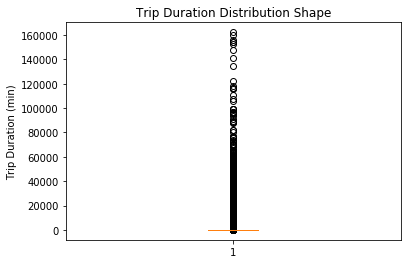

In [10]:
plt.boxplot(trip_info['trip duration (min)'])
plt.ylabel('Trip Duration (min)')
plt.title('Trip Duration Distribution Shape')
plt.show()

Unfortunately the box plot was not very useful in visulizing the shape of the distribution. Because the range of trip times seems to be so wide, break the data down into segments.

In [35]:
#select the data points with a trip duration less than or equal to 300 minutes or five hours
under_threehundred = trip_info.loc[trip_info['trip duration (min)']<=300]

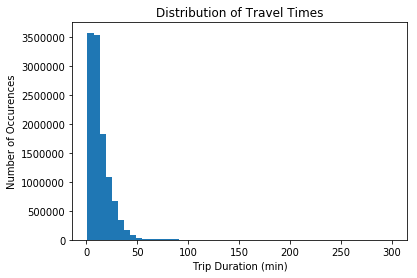

In [36]:
plt.hist(under_threehundred['trip duration (min)'], bins=50)
plt.xlabel('Trip Duration (min)')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Travel Times')
plt.show()

From this initial histogram, outliers seem to start around 100 minutes or longer. Let's hypothesize to see whether this is true for trips longer than 300 minutes.

In [37]:
#select the data points with a trip duration greater than 300 minutes or five hours
over_threehundred = trip_info.loc[trip_info['trip duration (min)']>300]

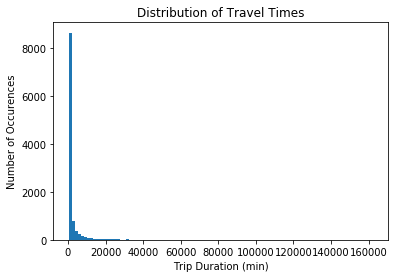

In [38]:
plt.hist(over_threehundred['trip duration (min)'], bins=100)
plt.xlabel('Trip Duration (min)')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Travel Times')
plt.show()

Even though under 300 minutes roughly only account for 68% or one standard deviation of the data (mean=16.35 minutes, standard deviation=290 minutes, and assuming a normal distriubution), the other 32% count for a wider range of outliers. This is supported by the above histogram whose occurences are much lower than the data under 300 minutes.

Let's also consider trip times ranging from 45-300 minutes

In [42]:
#select the data points with a trip duration betwee 45 and 300 minutes
fourtyfive_threehundred = trip_info.loc[(trip_info['trip duration (min)']>45)&(trip_info['trip duration (min)']<300)]

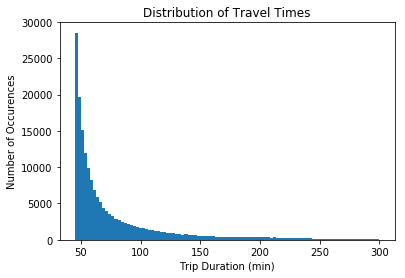

In [43]:
plt.hist(fourtyfive_threehundred['trip duration (min)'], bins=100)
plt.xlabel('Trip Duration (min)')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Travel Times')
plt.show()

Again, we can assume outliers exist within this segment of data.

Now, let's limit the dataset's max trip duration to 75 minutes, making the assumption that most rides realistically do not last for that duration, as each Citi Biki ride limit is either 30 or 45 min, and most riders would not wish to be heavily penalized for not re-docking their bikes.

In [10]:
#select data points with a trip duration betwee 45 and 300 minutes
ninety_data=trip_info.loc[trip_info['trip duration (min)'] <= 75]

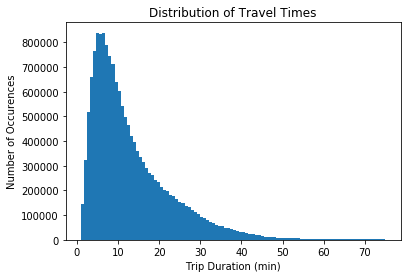

In [12]:
plt.hist(ninety_data['trip duration (min)'], bins=100)
plt.xlabel('Trip Duration (min)')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Travel Times')
plt.show()

In [14]:
ninety_data['trip duration (min)'].describe()

count    1.139018e+07
mean     1.303041e+01
std      9.752017e+00
min      1.016667e+00
25%      6.066667e+00
50%      1.006667e+01
75%      1.728333e+01
max      7.500000e+01
Name: trip duration (min), dtype: float64

Take a look at the station names. Upon some cross checking on Citi Bike's list of docking stations, some of the stations names in the dataset are not docking stations but workshops or depot centers. Other station names have labels "don't use". Remove all rows containing these anomalies.

In [11]:
#remove all starts and/or ends that dock at a NYCBS depot, are labeled "don't use", or get sent to a tech workshop 
drop_names = "depot|don't use|shop"
cleaned_data = ninety_data.loc[( ninety_data['start station name'].str.contains(drop_names) | 
                ninety_data['end station name'].str.contains(drop_names) )!= True]

To account for anomalies such as broken/malfunctioning bikes which get returned right away to the same station, drop all rows with the same start and end stations. This will drop many of the shorter 1 minute trip durations. Assume all normal trips start and end at unique stations, even if the trip is a only one block long.

Also drop any rows with duplicates or null values.

In [12]:
#Assume all trips made with the same start and end stations, A -> A, are anonmalies and remove these points. 
#For simplicity, only work with trips made from A -> B
cleaned_data=cleaned_data.loc[trip_info['start station name']!=trip_info['end station name']]

In [14]:
#check to see if duplicates exist
cleaned_data[cleaned_data.duplicated(keep=False)].sort_values(
    by=['start station name', 'end station name', 'trip duration (min)']).loc[:,('start time','stop time',
                                                                                 'start station name', 
                                                                                  'end station name', 
                                                                                'trip duration (min)')].head(10)

Empty DataFrame
Columns: [start time, stop time, start station name, end station name, trip duration (min)]
Index: []

In [13]:
#drop any duplicate rows
cleaned_data=cleaned_data.drop_duplicates()

#check if all duplicates are removed
print('Number of duplicates left in dataset: ' + str(cleaned_data[cleaned_data.duplicated(keep=False)].shape[0]))

Number of duplicates left in dataset: 0


In [17]:
#Check if null values exist in the dataset
print('Do null values exist in the dataset? ' + str(cleaned_data.isnull().values.any()))

Do null values exist in the dataset? True


In [15]:
#drop any null variables
cleaned_data=cleaned_data.dropna()

#Check if null values exist in the dataset
print('Do null values exist in the dataset? ' + str(cleaned_data.isnull().values.any()))

Do null values exist in the dataset? False


In [19]:
#Check if unknown genders exist in the dataset
cleaned_data['gender'].value_counts()

1    3284836
2    1113276
0      18974
Name: gender, dtype: int64

In [17]:
#drop any rows with an unknown (0) gender
cleaned_data=cleaned_data.loc[cleaned_data['gender']!=0]

#Check if unknown gender values, 0, exist in the dataset
print('Number of rows with unknown gender: ' + str(cleaned_data.loc[cleaned_data['gender']==0].shape[0]))

Number of rows with unknown gender: 0


Check whether there exist anomalies in ages such as 100+ years old riders and remove elderly riders.

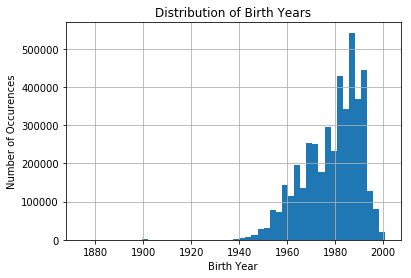

In [21]:
#check the distribution of birth years for any anomalies in age
cleaned_data['birth year'].hist(bins=50)
plt.xlabel('Birth Year')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Birth Years')
plt.show()

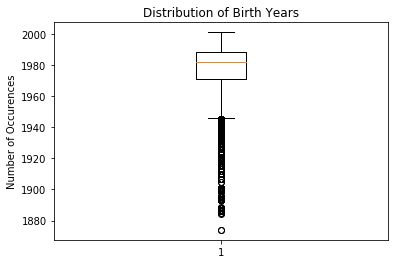

In [22]:
plt.boxplot(cleaned_data['birth year'])
plt.ylabel('Number of Occurences')
plt.title('Distribution of Birth Years')
plt.show()

In [23]:
cleaned_data['birth year'].describe()

count    4.398112e+06
mean     1.978901e+03
std      1.179336e+01
min      1.874000e+03
25%      1.971000e+03
50%      1.982000e+03
75%      1.988000e+03
max      2.001000e+03
Name: birth year, dtype: float64

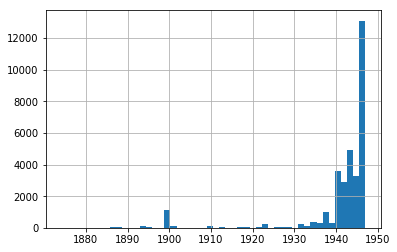

In [24]:
#Check data with riders 70+ years old
cleaned_data.loc[cleaned_data['birth year']<1948]['birth year'].hist(bins=50)

Remove all outliers indicated by the boxplot, birth years less than 1948, or 70+ year old riders

In [18]:
#drop rows with riders older than 70 (birth years less than 1948)
cleaned_data=cleaned_data.loc[cleaned_data['birth year']>=1948]

In [19]:
print('Number of rows in the cleaned dataset: ' + str(cleaned_data.shape[0]))

Number of rows in the cleaned dataset: 4365381


In [29]:
cleaned_data.head()

trip duration (min)           start time            stop time  \
1374378              9.083333  2017-02-24 18:40:45  2017-02-24 18:49:50   
6616775             35.566667  2017-06-27 19:51:01  2017-06-27 20:26:36   
9104357             27.300000  2017-08-10 16:10:13  2017-08-10 16:37:32   
9158690             12.116667  2017-08-11 12:34:01  2017-08-11 12:46:08   
16225942            11.716667  2017-12-21 19:18:35  2017-12-21 19:30:18   

            start station name  start station latitude  \
1374378        w 13 st & 6 ave               40.736494   
6616775     carroll st & 6 ave               40.674089   
9104357     e 60 st & york ave               40.759107   
9158690           3 st & 3 ave               40.675071   
16225942  grand st & greene st               40.721655   

          start station longitude         end station name  \
1374378                -73.997044       e 13 st & avenue a   
6616775                -73.978728    clinton st & union st   
9104357                -73.959223          6 ave & w 33 st   
9158690                -73.987752  schermerhorn st & 3 ave   
16225942               -74.002347        e 2 st & avenue c   

          end station latitude  end station longitude  bike id   user type  \
1374378              40.729554             -73.980572    24854  Subscriber   
6616775              40.683116             -73.997853    15114  Subscriber   
9104357              40.749013             -73.988484    30168  Subscriber   
9158690              40.686808             -73.980362    30020  Subscriber   
16225942             40.720874             -73.980858    15863  Subscriber   

          birth year  gender  
1374378       1992.0       1  
6616775       1962.0       2  
9104357       1972.0       1  
9158690       1978.0       1  
16225942      1983.0       2

Now that the dataset has been preprocessed, randomly sample two million datapoints for analysis, graphing visualizations, feature selection, and modeling. 

In [20]:
#randomly sample 1 million datapoints to analyze
sampled_data=cleaned_data.sample(n=1000000)

In [33]:
sampled_data.head()

trip duration (min)           start time            stop time  \
12770232            12.516667  2017-10-09 14:56:18  2017-10-09 15:08:49   
15039458             8.683333  2017-11-19 18:35:14  2017-11-19 18:43:55   
16045596            27.600000  2017-12-17 11:55:24  2017-12-17 12:23:01   
11315104             2.733333  2017-09-16 16:43:42  2017-09-16 16:46:26   
11090665             4.333333  2017-09-13 13:00:16  2017-09-13 13:04:37   

                start station name  start station latitude  \
12770232           e 25 st & 2 ave               40.739126   
15039458  bedford ave & nassau ave               40.723117   
16045596        broadway & w 51 st               40.762288   
11315104              5 st & 6 ave               40.670484   
11090665        broadway & w 24 st               40.742354   

          start station longitude         end station name  \
12770232               -73.979738          8 ave & w 16 st   
15039458               -73.952123   huron st & franklin st   
16045596               -73.983362       broadway & w 58 st   
11315104               -73.982090            6 ave & 12 st   
11090665               -73.989151  lexington ave & e 24 st   

          end station latitude  end station longitude  bike id   user type  \
12770232             40.740983             -74.001702    27622  Subscriber   
15039458             40.732660             -73.958260    14581  Subscriber   
16045596             40.766953             -73.981693    15557  Subscriber   
11315104             40.666318             -73.985462    26705  Subscriber   
11090665             40.740259             -73.984092    29806  Subscriber   

          birth year  gender  
12770232      1972.0       1  
15039458      1977.0       2  
16045596      1969.0       1  
11315104      1977.0       1  
11090665      1980.0       1

In [34]:
sampled_data.shape

(1000000, 13)

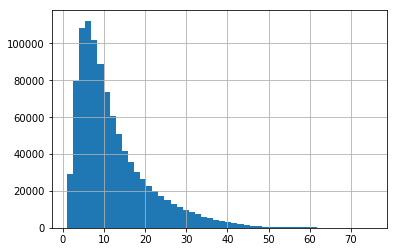

In [133]:
sampled_data['trip duration (min)'].hist(bins=50)

# Understanding and Preprocessing Ridership Data | Part 2

In [21]:
#new copy of cleaned dataset (in case errors are made later and need to go back to original)
added_features_df = sampled_data.copy()

In [152]:
#Create a new feature by splitting up "start time" to only the date and as a datetime type (will need later for merging weather data)
start_date=pd.DataFrame(pd.to_datetime(added_features_df['start time']).dt.normalize())

In [154]:
#add new feature to dataframe
added_features_df['start date']=start_date

In [24]:
#Create a new feature by splitting up "start time" to only time
start_time=pd.DataFrame(pd.to_datetime(added_features_df['start time']).dt.time)

In [25]:
#add new feature to dataframe
added_features_df['time']=start_time

In [26]:
#convert start and end coordinates into distance traveled between two points using Vincenty's formula
trip_dist=added_features_df.apply(lambda x: distance.distance((x['start station latitude'],
                                                          x['start station longitude']),
                                                         (x['end station latitude'],
                                                          x['end station longitude'])).miles, axis=1)

In [27]:
"""Each trip distance calculates the distance between start and end points but doesn't take actual roads/routes
into account. In most cases, the actual journey traveled will be longer. To account for the difference, 
multiply each trip distance by a factor of 1.25 """

added_features_df['est trip distance (mi)'] = trip_dist*1.25

In [28]:
#drop trip distances greater than 40 miles (in up to 75 minutes) as it's unlikely a biker would travel that far that fast
added_features_df=added_features_df.loc[added_features_df['est trip distance (mi)']<=40] 

In [29]:
#add a new feature, "trip rate (mph)", by calculating rate=distance/duration
dist_miles=added_features_df['est trip distance (mi)']
dur_hours=added_features_df['trip duration (min)']/60
added_features_df['trip rate (mph)']=dist_miles/dur_hours

In [30]:
#drop biking rates faster than 30 mph as most people bike below this rate, and accounting for traffic
added_features_df=added_features_df.loc[added_features_df['trip rate (mph)']<=30]

In [31]:
#add a new feature, 'age'
added_features_df['age']=2018-added_features_df['birth year']

Preprocessing is complete! Now, work with the preprocessed dataframe, "added_features_df", for all future visualizations and later modeling.

# Ridership Data Visualization

In [144]:
#KEEP THIS FOR NOW IN CASE WE DECIDE TO DELETE LATER
#added_features_df=added_features_df.drop('birth year',1)
#start_date=pd.DataFrame(added_features_df['start time'].str.split(expand=True)[0].sort_values())
#added_features_df=added_features_df.rename({'Try':'start date'}, axis=1)

### Question 1: Top 5 stations with the most starts (showing # of starts)

Use Folium to create a map of the top five start stations indicated by markers

In [84]:
#Obtain the names of the top five most visited start stations and their counts as a pd series
top_five_start_stations=added_features_df['start station name'].value_counts()[0:5]

In [706]:
top_five_start_stations

pershing square north    10708
e 17 st & broadway        7142
broadway & e 22 st        7025
w 21 st & 6 ave           6972
8 ave & w 31 st           6229
Name: start station name, dtype: int64

In [85]:
#obtain a five row dataset containing the top five starts. 
temp_coord_df=added_features_df[added_features_df['start station name'].isin(top_five_start_stations.index)]
temp_coord_df=temp_coord_df.drop_duplicates(subset='start station name')

In [86]:
#create a list of start station coordinates
start_station_coordinates=temp_coord_df.loc[:,['start station latitude', 'start station longitude']].values.tolist()

In [87]:
#cannot work with start names in a Series so create a list to store names as well
station_names=temp_coord_df['start station name'].values.tolist()
    

In [88]:
#create a dictionary with keys=start station names and values=station coordinates
station_coord_dict = {}
for i in range(len(station_names)):
    station_coord_dict[station_names[i]] = start_station_coordinates[i]

In [390]:
station_coord_dict

{'8 ave & w 31 st': [40.7505853470215, -73.9946848154068],
 'broadway & e 22 st': [40.740343200000005, -73.98955109],
 'e 17 st & broadway': [40.73704984, -73.99009296],
 'pershing square north': [40.751872999999996, -73.97770600000001],
 'w 21 st & 6 ave': [40.74173969, -73.99415556]}

In [89]:
#function which returns a map with the markers of the top five start stations
def station_map(coord_dict):
    nyc_map=folium.Map(location=[40.745168, -73.986831],zoom_start = 14)
    for key in coord_dict:
        icon_url = 'http://store-images.s-microsoft.com/image/apps.48501.14258686799584318.c1d778bd-9449-4923-87c7-6c4f884ce6f1.68e1d4c3-c209-4366-a298-32b787553c57'
        icon = folium.features.CustomIcon(icon_url,icon_size=(90, 90))
        folium.Marker(coord_dict[key], popup=key, icon=icon).add_to(nyc_map)
    return nyc_map

In [90]:
station_map(station_coord_dict)

Next, create a Seaborn bar chart of the number of counts for the top five start stations

In [91]:
#Create start station name labels which can be wrapped for aesthetics
text_wrap = textwrap.TextWrapper(width=9, break_on_hyphens=True)
top_station_labels=[]
for i in top_five_start_stations.index:
    top_station_labels.append(text_wrap.fill(i))
print(top_station_labels)

['pershing\nsquare\nnorth', 'broadway\n& e 22 st', 'w 21 st &\n6 ave', 'e 17 st &\nbroadway', '8 ave & w\n31 st']


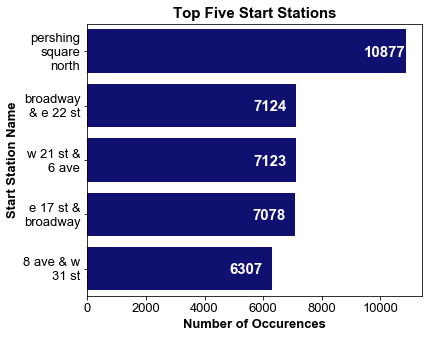

In [92]:
#bar chart of the number of counts for the top five start stations
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.barplot(top_five_start_stations.values, top_station_labels, color='navy', )
sns.set_style("darkgrid", {'axes.linewidth': 1.0, 'axes.grid': False})
plt.title('Top Five Start Stations', fontsize=15, weight='bold')
plt.ylabel('Start Station Name', fontsize=13, weight='bold')
plt.xlabel('Number of Occurences', fontsize=13, weight='bold')
plt.tick_params(labelsize=13)

#add total counts to each bar
for i, v in enumerate(top_five_start_stations.values):
    ax.text(v - 1450, i + .1, str(v), color='white', fontweight='bold', fontsize=15)

### Question 3. Most popular trips based on start station and stop station

In [93]:
added_features_df['start_end']=added_features_df['start station name']+ '-' +added_features_df['end station name']

In [94]:
top_five_trips=added_features_df.loc[:,'start_end'].value_counts().head().index

In [564]:
top_five_trips

Index(['e 7 st & avenue a-cooper square & e 7 st',
       'w 21 st & 6 ave-9 ave & w 22 st',
       'n 6 st & bedford ave-wythe ave & metropolitan ave',
       'pershing square north-e 24 st & park ave s',
       'pershing square north-broadway & w 32 st'],
      dtype='object')

In [95]:
#create a dataframe containing only rows with the top five trips
temp_top_five_coord_df=added_features_df[added_features_df['start_end'].isin(top_five_trips)]
temp_top_five_coord_df=temp_top_five_coord_df.drop_duplicates(subset='start_end')

In [96]:
#obtain start and end station coordinates
start_trip_coordinates=temp_top_five_coord_df.loc[:,['start station latitude', 
                                                    'start station longitude']]
end_trip_coordinates=temp_top_five_coord_df.loc[:,['end station latitude', 
                                                    'end station longitude']]

In [97]:
#change coordinates into tuples
start_coord_tuples = [tuple(x) for x in start_trip_coordinates.values]
end_coord_tuples = [tuple(x) for x in end_trip_coordinates.values]

In [98]:
#append coordinate pairs to a list
round_trip_coord_pairs=[]
for i, j in zip(start_coord_tuples, end_coord_tuples):
    round_trip_coord_pairs.append([i,j])

In [99]:
#create another list with all single coordinates, not as a start/end pair
one_way_coord=start_coord_tuples+end_coord_tuples
one_way_coord_pair=[list(i) for i in one_way_coord]

In [100]:
#create a dictionary with keys=start station names and values=station coordinates
one_way_coord_dict = {}
for i in range(len(top_five_trips)):
    one_way_coord_dict[top_five_trips[i]] = one_way_coord_pair[i]

In [101]:
#function which returns a map with top five trips and their start/end stations
def trip_journey(start_end_coord, one_way_coord):
    nyc_map=folium.Map(location=[40.745168, -73.986831],zoom_start = 14)
    for i in start_end_coord:
        folium.PolyLine(i, color="blue", weight=2.5, opacity=1).add_to(nyc_map)
    for i in one_way_coord:
        icon_url = 'http://store-images.s-microsoft.com/image/apps.48501.14258686799584318.c1d778bd-9449-4923-87c7-6c4f884ce6f1.68e1d4c3-c209-4366-a298-32b787553c57'
        icon = folium.features.CustomIcon(icon_url,icon_size=(60, 60))
        folium.Marker(i, icon=icon).add_to(nyc_map)
    return nyc_map

In [102]:
trip_journey(round_trip_coord_pairs, one_way_coord_pair)

### Question 5. What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?

In [103]:
#number of times the busiest bike was in use
most_pop_bike_count=added_features_df['bike id'].value_counts().max()
print("The number of times the busiest bike was in use: " +str(most_pop_bike_count))

The number of times the busiest bike was in use: 169


In [104]:
#id of the busiest bike
most_pop_bike_id=added_features_df['bike id'].value_counts().idxmax()
print("Busiest bike ID: " + str(most_pop_bike_id))

Busiest bike ID: 25429


In [105]:
#dataset of only the busiest bike
pop_bike_coord=added_features_df.loc[added_features_df['bike id']==most_pop_bike_id]

In [106]:
#total number of minutes biked
print("Total number of min used: " + str(pop_bike_coord['trip duration (min)'].sum()))

Total number of min used: 2123.016666666667


In [107]:
#obtain two lists of lat/long pairs, one for start and one for stop
bike_start=pop_bike_coord.loc[:,['start station latitude', 'start station longitude']].values.tolist()
bike_stop=pop_bike_coord.loc[:,['end station latitude', 'end station longitude']].values.tolist()

In [108]:
#concatenate the start/stop coordinates for the busiest bike into one list
start_stop_bike_coord=bike_start+bike_stop

In [109]:
#function returns a heatmap of all visited start and stop station in 2017
def busiest_bike_heatmap(heatmap_coord):
    nyc_map=folium.Map(location=[40.745168, -73.986831],zoom_start = 12)
    HeatMap(heatmap_coord).add_to(nyc_map)
    return nyc_map

In [110]:
busiest_bike_heatmap(start_stop_bike_coord)

### Question 4a. Trip Rate by Gender and Age

In [33]:
#new subset to answer questions involving gender
trip_data_by_age_gender=added_features_df.loc[:,['start station name','end station name','est trip distance (mi)',
                                             'trip duration (min)','trip rate (mph)', 'age', 'gender', 'user type']]

In [48]:
#replace 1 and 2 with M and F respectively
trip_data_by_age_gender['gender'].replace([1, 2],["M","F"],inplace=True)

In [49]:
#male=trip_data_by_age_gender.loc[trip_data_by_age_gender['gender']=="M"]
#female=trip_data_by_age_gender.loc[trip_data_by_age_gender['gender']=="F"]

In [41]:
#assign age groups to each rider
age_groups=[]
for i in trip_data_by_age_gender['age']:
    if i < 20:
        age_groups.append("Under 20")
    elif 20 <= i < 40:
        age_groups.append("20-40")
    elif 40 <= i < 60:
        age_groups.append("40-60")
    else:
        age_groups.append("60+")

In [42]:
#add new feature, "age groups"
trip_data_by_age_gender['age group']=age_groups

In [65]:
#sort dataset by age
trip_data_by_age_gender=trip_data_by_age_gender.sort_values(by='age')

In [50]:
#datasets for male and female data respectively
male_n_by_age=trip_data_by_age_gender.loc[trip_data_by_age_gender['gender']=="M"]['age group'].value_counts()
female_n_by_age=trip_data_by_age_gender.loc[trip_data_by_age_gender['gender']=="F"]['age group'].value_counts()


In [45]:
age_group_labels=trip_data_by_age_gender['age group']
age_group_labels=age_group_labels.drop_duplicates()

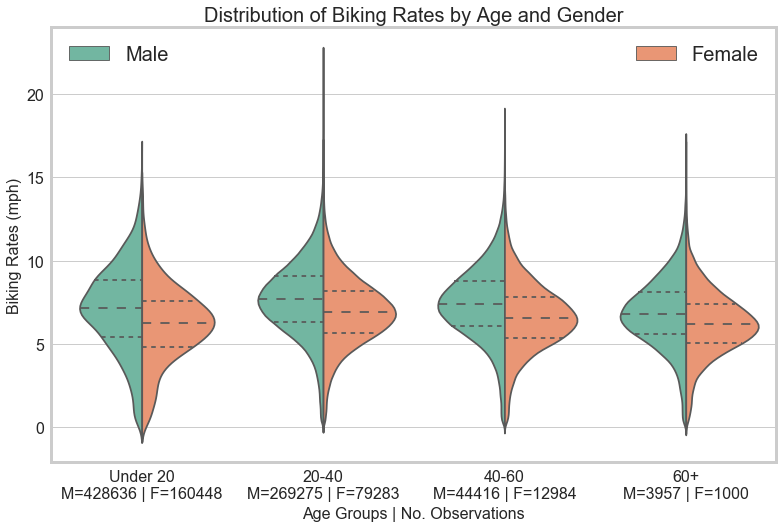

In [683]:
#create a violinplot to show distribution of trip rates by age and gender
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_style("whitegrid",{'axes.linewidth': 3.0})

ax=sns.violinplot(x="age group", y="trip rate (mph)", hue=("gender"), 
               data=trip_data_by_age_gender, palette="Set2", split=True, inner="quartile") #palette="muted"

# Set legend #
handles, labels = ax.get_legend_handles_labels()
l1=ax.legend([handles[0]], ["Male"], loc=2)
l2=ax.legend([handles[1]], ["Female"], loc=1)
gca().add_artist(l1)

ax.axes.set_title("Distribution of Biking Rates by Age and Gender",fontsize=20)
ax.set_xlabel("Age Groups | No. Observations",fontsize=16)
ax.set_ylabel("Biking Rates (mph)",fontsize=16)
ax.tick_params(labelsize=16)
x_labels=[]
for m,f,l in zip(male_n_by_age, female_n_by_age, age_group_labels):
    label=l+'\n'+'M='+str(m)+' | F='+str(f)
    x_labels.append(label)
ax.set_xticklabels(x_labels)
plt.show()

### Question 4b. Average Trip Distance by Gender and Age

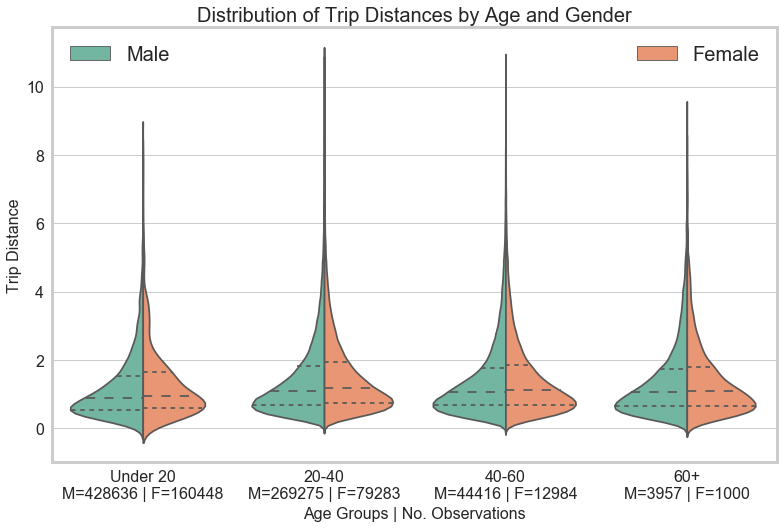

In [687]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_style("whitegrid", {'axes.linewidth': 3.0, 'ytick.major.size': 1.0})

ax=sns.violinplot(x="age group", y="est trip distance (mi)", hue=("gender"), 
               data=trip_data_by_age_gender, palette="Set2", split=True, inner="quartile") #palette="muted"

# Set legend #
handles, labels = ax.get_legend_handles_labels()
l1=ax.legend([handles[0]], ["Male"], loc=2)
l2=ax.legend([handles[1]], ["Female"], loc=1)
gca().add_artist(l1)

ax.axes.set_title("Distribution of Trip Distances by Age and Gender",fontsize=20)
ax.set_xlabel("Age Groups | No. Observations",fontsize=16)
ax.set_ylabel("Trip Distance",fontsize=16)
ax.tick_params(labelsize=16)
x2_labels=[]
for m,f,l in zip(male_n_by_age, female_n_by_age, age_group_labels):
    label=l+'\n'+'M='+str(m)+' | F='+str(f)
    x2_labels.append(label)
ax.set_xticklabels(x2_labels)
plt.show()

Create an additional bubble chart to observe size of data grouped by gender and age.

In [78]:
males=trip_data_by_age_gender[trip_data_by_age_gender['gender']=='M']
females=trip_data_by_age_gender[trip_data_by_age_gender['gender']=='F']

In [79]:
#males.groupby('age group')['trip rate (mph)'].sum()
m_counts=[]
m_all_other_ages=males.groupby('age group').size()[0:3]
m_under_twenty=males.groupby('age group').size()[3]
m_counts.append(m_under_twenty)
for i in m_all_other_ages:
    m_counts.append(i)

#male_rates.append(all_other_ages)

In [80]:
f_counts=[]
f_all_other_ages=females.groupby('age group').size()[0:3]
f_under_twenty=females.groupby('age group').size()[3]
f_counts.append(f_under_twenty)
for i in f_all_other_ages:
    f_counts.append(i)
all_counts=m_counts+f_counts

In [81]:
#init_notebook_mode(connected=True)
trace0 = go.Scatter(
    x=['Under 20', '20-40', '40-60', '60+'],
    y=m_counts,
    mode='markers',
    name='Male',
    marker=dict(size=m_counts, sizemode='area', sizeref=2.*max(all_counts)/(150.**2), sizemin=4,
               color=['rgb(44, 160, 101)' for i in m_counts]))

trace1 = go.Scatter(
    x=['Under 20', '20-40', '40-60', '60+'],
    y=f_counts,
    mode='markers',
    name='Female',
    marker=dict(size=f_counts, sizemode='area', sizeref=2.*max(all_counts)/(150.**2), sizemin=4))
size = go.Layout(
    title='Rider Population by Age and Gender',
    autosize=False,
    width=850,
    height=600,
    xaxis=dict(
        title='Age Groups',
        zerolinewidth=0,
        showgrid=False,
    ),
    yaxis=dict(
        title='Number of Riders',
        zeroline=False,
    )
    )            

all_data = [trace0, trace1]
fig=go.Figure(data=all_data,layout=size)
py.offline.iplot(fig, filename='bubblechart-size')


### Question 2: Trip Duration by User Type

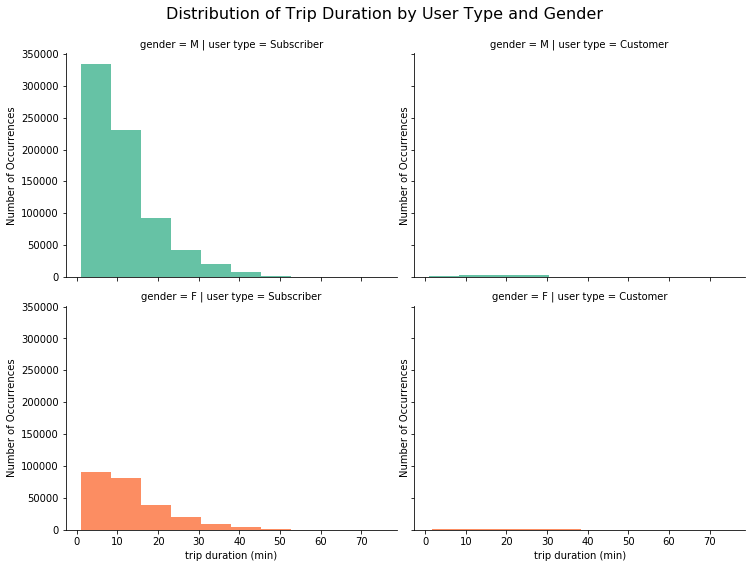

In [82]:
h=sns.FacetGrid(trip_data_by_age_gender, col ='user type', row ='gender', hue='gender', palette = 'Set2', aspect=1.3, size=4)
h.map(plt.hist, 'trip duration (min)', )
#plt.title("Distribution of Trip Duration by User Type and Gender")
#plt.ylabel("Number of Occurrences")
h.axes[0,0].set_ylabel('Number of Occurrences')
h.axes[0,1].set_ylabel('Number of Occurrences')
h.axes[1,1].set_ylabel('Number of Occurrences')
h.axes[1,0].set_ylabel('Number of Occurrences')
plt.subplots_adjust(top=.9)
h.fig.suptitle('Distribution of Trip Duration by User Type and Gender', fontsize=16)
plt.show()

That concludes the five data visualization questions.

# New Kiosk Feature: Travel Time Prediction


### Model 1: Linear Regression

First try linear regression on one variable, "trip duration", to see whether this ML algo is appropriate for solving the given problem statement.

In [38]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [167]:
X_data=trip_data_by_age_gender['est trip distance (mi)'].values.reshape(-1,1) #X_data needs to be a 2D array
y_data=trip_data_by_age_gender['trip duration (min)']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.33, random_state = 7)

In [169]:
reg=linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)

In [170]:
y_pred

array([ 7.41887052,  6.38070587,  5.1387577 , ...,  4.69004433,
        4.66597185, 35.49722259])

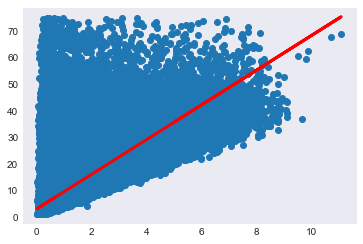

In [174]:
#plt.scatter(trip_data_by_age_gender['est trip distance (mi)'], y_data)
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c="red", linewidth=3)
plt.show()

As we can see from this scatter plot of test points, the linear model we just created does a poor job of predicting time travel as trip distance does not necessarily correlate with time. 

Let's first bring in an NYC weather dataset and then work on a different model.

### Weather Data: Aggregate and merge 2017 NYC weather data obtained from https://www.ncdc.noaa.gov/cdo-web/datasets

In [ ]:
weather_csv=r'C:\Users\XinranPan\Documents\NYC Weather Data 2017.csv'
weather_data=pd.read_csv(weather_csv)
weather_date=pd.DataFrame(pd.to_datetime(weather_data['date']))
weather_data.insert(loc=0, column='start date', value=weather_date)
weather_data=weather_data.drop('date',1)

In [165]:
merged_weather_data=pd.merge(added_features_df, weather_data,
                 on='start date', 
                 how='left')
print('Do null values exist in the merged dataset? ' + str(merged_weather_data.isnull().values.any()))
merged_weather_data.sort_values(by=['start date', 'time'])

Do null values exist in the merged dataset? False


trip duration (min)           start time            stop time  \
465620            25.066667  2017-01-01 00:09:29  2017-01-01 00:34:34   
461857            19.550000  2017-01-01 00:12:40  2017-01-01 00:32:14   
678473            11.966667  2017-01-01 00:17:50  2017-01-01 00:29:48   
680624             5.016667  2017-01-01 00:17:50  2017-01-01 00:22:52   
448011             4.166667  2017-01-01 00:19:24  2017-01-01 00:23:34   
596711            41.283333  2017-01-01 00:20:18  2017-01-01 01:01:35   
370815            22.833333  2017-01-01 00:24:47  2017-01-01 00:47:37   
667778             3.833333  2017-01-01 00:25:39  2017-01-01 00:29:30   
845655             6.233333  2017-01-01 00:26:23  2017-01-01 00:32:38   
292402             7.316667  2017-01-01 00:30:03  2017-01-01 00:37:23   
308007            11.300000  2017-01-01 00:34:31  2017-01-01 00:45:49   
250750            24.733333  2017-01-01 00:44:27  2017-01-01 01:09:11   
152960             5.600000  2017-01-01 00:45:46  2017-01-01 00:51:22   
153146            25.150000  2017-01-01 00:45:47  2017-01-01 01:10:56   
644452             1.816667  2017-01-01 00:49:37  2017-01-01 00:51:27   
143690            21.100000  2017-01-01 00:51:31  2017-01-01 01:12:38   
553478             6.616667  2017-01-01 00:51:33  2017-01-01 00:58:11   
678026             1.033333  2017-01-01 00:53:25  2017-01-01 00:54:28   
129125             7.166667  2017-01-01 00:55:09  2017-01-01 01:02:19   
780696            14.216667  2017-01-01 01:01:47  2017-01-01 01:16:01   
627204            10.433333  2017-01-01 01:03:40  2017-01-01 01:14:06   
599189            12.216667  2017-01-01 01:09:44  2017-01-01 01:21:57   
532070            12.750000  2017-01-01 01:10:03  2017-01-01 01:22:48   
590664            14.133333  2017-01-01 01:13:04  2017-01-01 01:27:12   
81493              6.916667  2017-01-01 01:13:42  2017-01-01 01:20:38   
231075            11.200000  2017-01-01 01:20:58  2017-01-01 01:32:11   
664312             5.166667  2017-01-01 01:23:07  2017-01-01 01:28:18   
123541             6.133333  2017-01-01 01:25:49  2017-01-01 01:31:57   
14954             13.050000  2017-01-01 01:28:44  2017-01-01 01:41:48   
624356             3.950000  2017-01-01 01:31:14  2017-01-01 01:35:11   
...                     ...                  ...                  ...   
981957            28.766667  2017-12-31 20:01:04  2017-12-31 20:29:51   
467282            33.500000  2017-12-31 20:02:13  2017-12-31 20:35:44   
707202             6.266667  2017-12-31 20:07:00  2017-12-31 20:13:17   
980348             4.566667  2017-12-31 20:18:02  2017-12-31 20:22:37   
202765             4.283333  2017-12-31 20:23:32  2017-12-31 20:27:49   
461429            20.883333  2017-12-31 20:28:58  2017-12-31 20:49:51   
970118            14.433333  2017-12-31 20:32:09  2017-12-31 20:46:35   
994157             5.933333  2017-12-31 20:40:28  2017-12-31 20:46:24   
571183             7.200000  2017-12-31 20:42:59  2017-12-31 20:50:12   
866187            14.600000  2017-12-31 20:46:15  2017-12-31 21:00:52   
382026             8.933333  2017-12-31 20:48:23  2017-12-31 20:57:20   
272605             6.966667  2017-12-31 20:52:35  2017-12-31 20:59:33   
904940            27.450000  2017-12-31 20:56:56  2017-12-31 21:24:23   
391548            10.316667  2017-12-31 21:00:47  2017-12-31 21:11:06   
549730             8.716667  2017-12-31 21:03:10  2017-12-31 21:11:54   
400498             9.550000  2017-12-31 21:05:39  2017-12-31 21:15:12   
724940             2.516667  2017-12-31 21:19:25  2017-12-31 21:21:57   
847461             7.066667  2017-12-31 21:22:43  2017-12-31 21:29:48   
527793            13.916667  2017-12-31 21:33:54  2017-12-31 21:47:49   
129633             2.933333  2017-12-31 21:37:01  2017-12-31 21:39:57   
223946             5.666667  2017-12-31 21:40:33  2017-12-31 21:46:14   
775559            17.466667  2017-12-31 21:53:27  2017-12-31 22:10:56   
841817            28.116667  2017-12-31 21:55:36  2017-12-31 22:23

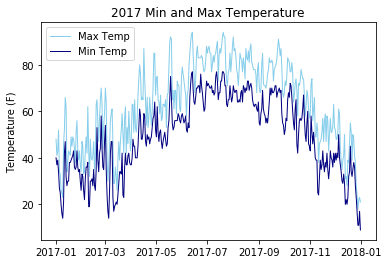

In [192]:
#graph the max and min temperatures for observation
fig, ax = plt.subplots()
ax.plot('start date', 'max temperature', data=weather_data, label='Max Temp', color='skyblue', linewidth=1)
ax.plot('start date', 'min temperature', data=weather_data, label='Min Temp', color='navy', linewidth=1)
plt.ylabel('Temperature (F)')
plt.title('2017 Min and Max Temperature')
plt.legend()
plt.show()

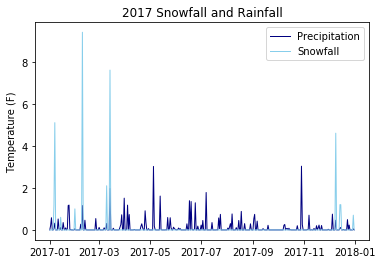

In [196]:
#Graph of weather elements for 2017
fig, ax = plt.subplots()
ax.plot('start date', 'precipitation', data=weather_data, label='Precipitation', color='navy', linewidth=1)
ax.plot('start date', 'snowfall', data=weather_data, label='Snowfall', color='skyblue', linewidth=1)
#ax.plot('start date', 'avg wind speed', data=weather_data, label='Min Temp', color='navy', linewidth=1)
plt.ylabel('Temperature (F)')
plt.title('2017 Snowfall and Rainfall')
plt.legend()
plt.show()

In [175]:
#make a new copy of the merged data to work with
all_features=merged_weather_data.copy()

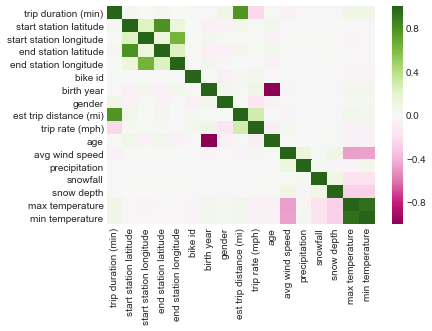

In [177]:
correlation = all_features.corr()
sns.heatmap(correlation, cmap='PiYG')
plt.show()

In [178]:
#drop redundant features as indicated by the heatmap. Assume bike ID has an insignificant affect on trip times
all_features=all_features.drop('birth year', 1)
all_features=all_features.drop('bike id', 1)

In [179]:
all_features.columns

Index(['trip duration (min)', 'start time', 'stop time', 'start station name',
       'start station latitude', 'start station longitude', 'end station name',
       'end station latitude', 'end station longitude', 'user type', 'gender',
       'start date', 'time', 'est trip distance (mi)', 'trip rate (mph)',
       'age', 'start_end', 'avg wind speed', 'precipitation', 'snowfall',
       'snow depth', 'max temperature', 'min temperature'],
      dtype='object')

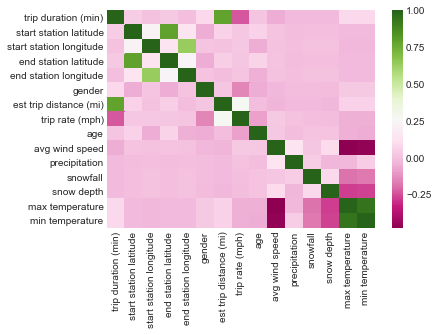

In [180]:
correlation = all_features.corr()
sns.heatmap(correlation, cmap='PiYG')
plt.show()

In [326]:
all_features=all_features.sort_values(by=['start date', 'time'])

In [182]:
#changeback from datetime to string for encoding purposes for the xgb model arguments
all_features['strt date']=all_features['start date'].dt.strftime("%Y-%m-%d")

In [184]:
#remove the datetime feature "start date" and only use the new string feature
all_features=all_features.drop('start date',1)

In [196]:
all_features=all_features.drop('time',1)

### Model 2: XGBoost

In [197]:
#encode non ints and floats
encoded_strings=all_features.loc[:,['strt date','start time', 'stop time', 'start station name', 'end station name', 
                           'user type','gender']]

In [198]:
#df of ints and float elements
non_encoded=all_features.loc[:,[
       'start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude',
       'est trip distance (mi)', 'trip rate (mph)', 'age',
       'avg wind speed', 'precipitation', 'snowfall', 'snow depth',
       'max temperature', 'min temperature']]

In [201]:
#encode the features with string values
strings=encoded_strings.apply(LabelEncoder().fit_transform)

In [202]:
non_encoded['start date']=strings['strt date']
non_encoded['start time']=strings['start time']
non_encoded['stop time']=strings['stop time']
non_encoded['start station name']=strings['start station name']
non_encoded['end station name']=strings['end station name']
non_encoded['user type']=strings['user type']
non_encoded['gender']=strings['gender']

In [205]:
#feature names - do not include the feature variable, "trip duration (min)"
ft_names=non_encoded.columns.values

In [206]:
#print the list of features to be used in the XGBoost model
ft_names

array(['start station latitude', 'start station longitude',
       'end station latitude', 'end station longitude',
       'est trip distance (mi)', 'trip rate (mph)', 'age',
       'avg wind speed', 'precipitation', 'snowfall', 'snow depth',
       'max temperature', 'min temperature', 'start date', 'start time',
       'stop time', 'start station name', 'end station name', 'user type',
       'gender'], dtype=object)

In [231]:
#obtain X and y datasets. Also try log(y)
#non_encoded is a bad var name, actually contains both encoded and non_encoded. Don't change though bc prone to errors, just remember what var is
X_data=non_encoded[ft_names]
y_data=all_features['trip duration (min)']
ylog_data=np.log(all_features['trip duration (min)']+1) #try the log as well?

In [232]:
#split into 60% training set, 20% validation set, and 20% test set
X_train, X_temp, y_train, y_temp = train_test_split(X_data, ylog_data, test_size = 0.4, random_state = 7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 7)

In [211]:
#test that the shapes are correct before delving into the model
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(599999, 20)
(599999,)
(200000, 20)
(200000,)
(200000, 20)
(200000,)


In [233]:
#training and validation DMatrices for xgb model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)
val_set = [(dtrain, 'train'), (dvalid, 'valid')]

In [222]:
#xgb parameters for parameter tuning
xgb2={'min_child_weight': 20, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 15,
            'subsample': 0.9, 'lambda': 2.0, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [234]:
model_1 = xgb.train(xgb2, dtrain, 10, val_set, early_stopping_rounds=40, verbose_eval=10)
#end = time.time()
#print("Time taken by above cell is {}.".format(end - start))
#print('Modeling RMSLE %.5f' % model_1.best_score)

[0]	train-rmse:1.8948	valid-rmse:1.89385
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[9]	train-rmse:1.22213	valid-rmse:1.22194


In [224]:
print('Modeling RMSLE %.5f' % model_1.best_score)

Modeling RMSLE 1.17899


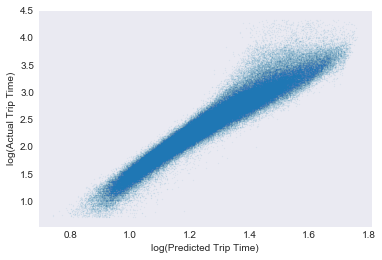

In [239]:
#graph the performance of the log validation set
ypred = model_1.predict(dvalid)
fig,ax = plt.subplots()
ax.scatter(ypred, y_val, s=0.1, alpha=0.1)
#ax.scatter(np.exp(ypred), np.exp(y_val), s=0.1, alpha=0.1)
ax.set_xlabel('log(Predicted Trip Time)')
ax.set_ylabel('log(Actual Trip Time)')
plt.show()

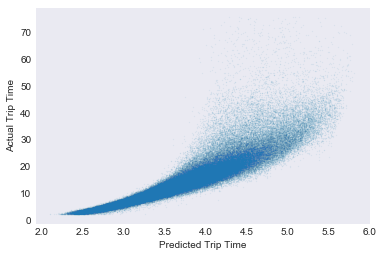

In [238]:
#graph the performance of the validation set
ypred = model_1.predict(dvalid)
fig,ax = plt.subplots()
#ax.scatter(ypred, y_val, s=0.1, alpha=0.1)
ax.scatter(np.exp(ypred), np.exp(y_val), s=0.1, alpha=0.1)
ax.set_xlabel('Predicted Trip Time')
ax.set_ylabel('Actual Trip Time')
plt.show()

Not bad but could use improvement as trip time increases. This will do for now.

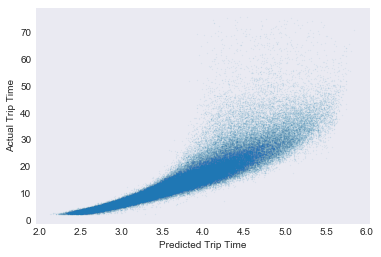

In [240]:
#graph the performance of the test set
ypred = model_1.predict(dtest)
fig,ax = plt.subplots()

ax.scatter(np.exp(ypred), np.exp(y_test), s=0.1, alpha=0.1)
ax.set_xlabel('Predicted Trip Time')
ax.set_ylabel('Actual Trip Time')
plt.show()

### Time Travel Prediction

In [282]:
#['w 21 st & 6 ave', '9 ave & w 22 st'].apply(LabelEncoder().fit_transform)
#create a dictionary with keys=start station names and values=station coordinates
encode_dict = {}
code_names=non_encoded['start station name'].values.tolist()
noncode_names=all_features['start station name'].values.tolist()
code_names.extend(non_encoded['end station name'].values.tolist())
noncode_names.extend(all_features['end station name'].values.tolist())
for i in range(len(noncode_names)):
    encode_dict[noncode_names[i]] = code_names[i]

In [393]:
"""Function to calculate travel time. Takes a start station name and end station name and locates corresponding coordinates. 
Then, calculates the distance between the two coordinate points and multiplies it by a factor of 1.25 just like in the
previous distance calculation. Locates the first row of datapoints with the same trip distance from the model's
full features dataset (X_data) and uses this singular datapoint to predict the trip time. In other words, plug in
this datapoint into the XGBoost model to predict trip time. This function returns:
start station | end station | trip distance | predicted travel time
"""
def predict_travel_time(start, end):
    start=start.lower()
    end=end.lower()
    #start_end=start+"-"+end
    coord_df=non_encoded.loc[(non_encoded['start station name']==encode_dict[start]) & (non_encoded['end station name']==encode_dict[end])]
    coord=coord_df.iloc[0:1,:]
    start_x=coord['start station latitude'].values.tolist()
    start_y=coord['start station longitude'].values.tolist()
    end_x=coord['end station latitude'].values.tolist()
    end_y=coord['end station longitude'].values.tolist()
    start_d=(start_x[0],start_y[0])
    end_d=(end_x[0],end_y[0])
    d=distance.distance(start_d, end_d).miles*1.25
    datapoint=X_data.loc[X_data['est trip distance (mi)']==d].iloc[0:1,:]
    predicted_time=model_1.predict(xgb.DMatrix(datapoint))
    time=np.exp(predicted_time[0])
    msg="Start: " + start.upper()+"  |  "+ "Destination: "+ end.upper() +"  |  "+"Trip Distance: "+str(round(d,2))+"  |  "+"Predicted Travel Time: "+str(round(time,2))
    return msg

In [394]:
#try predictions on real start and stop stations
predict_travel_time('w 21 st & 6 ave','9 ave & w 22 st')
#print("Start: " + str)

'Start: W 21 ST & 6 AVE  |  Destination: 9 AVE & W 22 ST  |  Trip Distance: 0.21  |  Predicted Travel Time: 2.67'

In [397]:
#try predictions on real start and stop stations
predict_travel_time('n 6 st & bedford ave','wythe ave & metropolitan ave')

'Start: N 6 ST & BEDFORD AVE  |  Destination: WYTHE AVE & METROPOLITAN AVE  |  Trip Distance: 0.48  |  Predicted Travel Time: 2.58'

In [398]:
#try predictions on real start and stop stations
predict_travel_time('Pershing Square North','e 24 st & park ave s')


'Start: PERSHING SQUARE NORTH  |  Destination: E 24 ST & PARK AVE S  |  Trip Distance: 1.06  |  Predicted Travel Time: 3.52'